In [113]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from skforecast.datasets import fetch_dataset

# Importation des modeles
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.plot import set_dark_theme

In [114]:
# Constantes
HORIZON=24
TEST_SIZE = 24
VAL_SIZE = 12
LAG_SIZE = 6
WINDOW_SIZE = 4

In [115]:
# Liste des modèles à comparer
models = {
    'XGBoost': {
        "alg": xgb.XGBRegressor(objective='reg:squarederror', verbosity=0),
        "params_grid_search": {
            "eta": [0.1, 0.3],
            "n_estimators": [50, 100]
        }
    },
    "RegressionLineaire": {
        "alg": LinearRegression(),
        "params_grid_search": None
    },
    'Ridge': {
        "alg": Ridge(alpha=1.0),
        "params_grid_search": {
            "alpha": [0.1, 0.5, 1.0]
        }
    },
    'LightGBM': {
        "alg": LGBMRegressor(n_estimators=100, learning_rate=0.2, verbosity=-1),
        "params_grid_search": {
            "learning_rate": [0.1, 0.2],
            "n_estimators": [50, 100]
        }
    },
    # 'RandomForrest': {
    #     "alg": RandomForestRegressor(random_state=42, criterion="absolute_error"),
    #     "params_grid_search": {
    #         "n_estimators": [50, 100],
    #         "max_depth": [None, 10, 20]
    #     }
    # }
}

# Pour stocker les performances
performance = {
    name: {"rmse": None, "mae": None, "mape": None}
    for name in models
}
# Les meilleurs parametre pour chaque modele
best_parameters = {name: {} for name in models}


In [116]:
# Les poids pour chaque metric
weights = {
    'RMSE': 0.4,
    'MAE': 0.3,
    'MAPE': 0.3
}

### Les fonctions utillisé

**Fonction pour charger les données**

In [117]:
def load_data(path="../../data/raw/train.csv"):
    """
    Charger les données à partir d'un fichier CSV ou base de donnée."""
    # Charger les données
    # if type(path)=="str":
    data = pd.read_csv(path, delimiter=',', header=0, parse_dates=True, index_col=0)
    data = data.sort_index()
    data = data.sort_values(by=["item", "store"])
    return data

**Fonction pour rendre le donnée utilisable le ForecasterRecursiveMultiSeries**

In [118]:
def pivot_full_series(data, start_date, end_date):
    """
    Crée un DataFrame avec full_range en index et chaque colonne = produit-store.
    Les dates manquantes sont remplies avec 0.
    """
    # Convertir en datetime
    data = data.copy()
    
    # S'assurer que l'index est bien la date
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
        data = data.set_index('date')

    # Créer la clé colonne "produit-store"
    data['produit_store'] = data['item'].astype(str) + '-' + data['store'].astype(str)

    # Pivot
    pivot = data.pivot_table(
        index='date',
        columns='produit_store',
        values='sales',  # <-- à adapter si ta colonne s'appelle différemment
        aggfunc='sum'
    )

    # Reindex sur full_range
    full_range = pd.date_range(start=start_date, end=end_date, freq='D')
    pivot = pivot.reindex(full_range)

    # Remplir les valeurs manquantes avec 0
    pivot.fillna(0, inplace=True)

    return pivot


**Fonction pour calculer la performance**

In [119]:
def compute_metrics_per_column(y_true, y_pred):
    metrics = {}
    for col in y_true.columns:
        rmse = np.sqrt(mean_squared_error(y_true[col], y_pred[col]))
        mae = mean_absolute_error(y_true[col], y_pred[col])
        mape = mean_absolute_percentage_error(y_true[col], y_pred[col]) * 100
        metrics[col] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
    return pd.DataFrame(metrics).T  # transpose for readability

### Chargement de donnée

In [120]:
data=load_data()
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


### Pivoter le dataframe pour avoir la forme :
**date(index) | serie_1 | serie_2 | serie_3** 

In [121]:
df_pivot = pivot_full_series(data, start_date=data.index.min(), end_date=data.index.max())

In [122]:
df_pivot.head()

produit_store,1-1,1-10,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,...,9-1,9-10,9-2,9-3,9-4,9-5,9-6,9-7,9-8,9-9
2013-01-01,13,14,12,19,10,11,20,7,16,11,...,18,23,28,28,19,21,25,27,29,27
2013-01-02,11,14,16,8,12,9,6,4,10,9,...,23,23,21,16,21,20,17,20,28,36
2013-01-03,14,16,16,10,8,12,11,8,12,20,...,25,37,29,32,25,15,28,18,31,25
2013-01-04,13,17,20,15,15,8,7,7,21,22,...,22,28,32,40,37,20,33,24,46,31
2013-01-05,10,12,16,22,19,13,12,8,15,22,...,29,35,45,44,37,23,27,14,35,30


In [123]:
df_pivot.shape

(1826, 500)

### Resample du donnee pour qu'il soit hebdomadaire

In [124]:
df_weekly = df_pivot.resample('W').sum()

### Creation de feature temporelle

In [125]:
df_weekly["year"]= df_weekly.index.year
df_weekly["month"]= df_weekly.index.month
df_weekly["quarter"]= df_weekly.index.quarter
df_weekly.head()

produit_store,1-1,1-10,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,...,9-3,9-4,9-5,9-6,9-7,9-8,9-9,year,month,quarter
2013-01-06,73,84,98,96,78,68,65,44,101,95,...,194,176,128,150,127,203,184,2013,1,1
2013-01-13,66,117,116,87,107,78,78,47,86,81,...,233,199,148,173,139,237,215,2013,1,1
2013-01-20,80,103,113,110,84,56,62,63,99,95,...,235,220,156,160,149,254,226,2013,1,1
2013-01-27,70,95,100,102,75,58,50,63,100,86,...,228,228,168,157,148,268,202,2013,1,1
2013-02-03,86,100,112,118,99,73,66,76,101,123,...,232,244,173,170,143,252,258,2013,2,1


### Division de donnée en train - test - validation

In [126]:
train_set=df_weekly.iloc[:-(VAL_SIZE+TEST_SIZE)].copy()
val_set=df_weekly.iloc[-(VAL_SIZE+TEST_SIZE):-TEST_SIZE]
test_set=df_weekly.iloc[-TEST_SIZE:].copy()
print(f"Dataset shape: {df_weekly.shape[0]}")

print(
    f"Train dates : {train_set.index.min()} --- {train_set.index.max()}   "
    f"(n={len(train_set)})"
)
print(
    f"Validation dates  : {val_set.index.min()} --- {val_set.index.max()}   "
    f"(n={len(val_set)})"
)
print(
    f"Test dates  : {test_set.index.min()} --- {test_set.index.max()}   "
    f"(n={len(test_set)})"
)

Dataset shape: 261
Train dates : 2013-01-06 00:00:00 --- 2017-04-23 00:00:00   (n=225)
Validation dates  : 2017-04-30 00:00:00 --- 2017-07-16 00:00:00   (n=12)
Test dates  : 2017-07-23 00:00:00 --- 2017-12-31 00:00:00   (n=24)


### Affichage de la graphique du donnee train-test-val

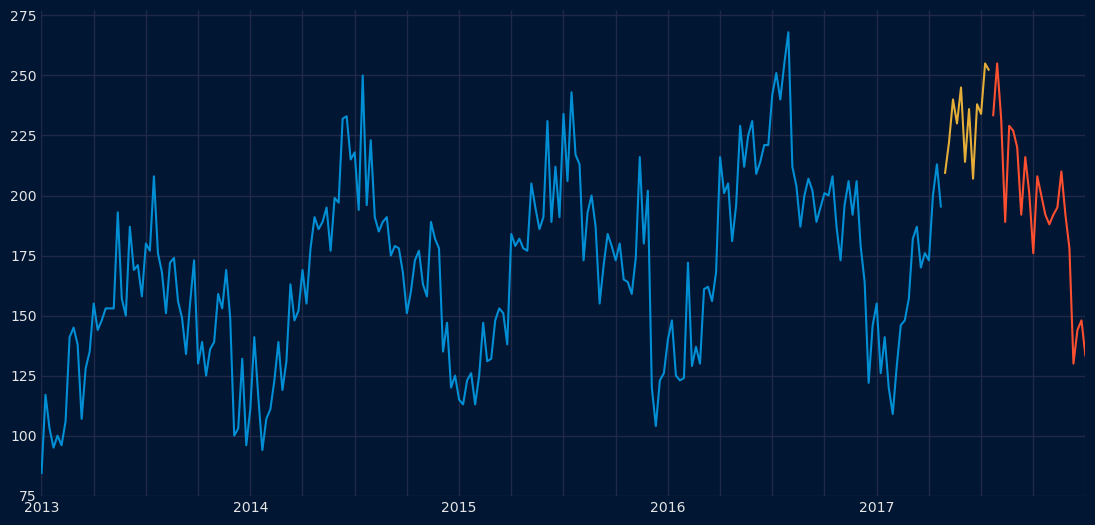

In [127]:
plt.figure(figsize=(12, 6))
set_dark_theme()
train_set.iloc[:,1].plot(label='train')
test_set.iloc[:,1].plot(label='test')
val_set.iloc[:,1].plot(label='test')
plt.show();

### Recherche d'hyperparametre pour chaque modele

In [128]:
for model_name, model in models.items():
    print(f"En cours : {model_name}")
    
    # Initialisation du modèle
    forecaster = ForecasterRecursiveMultiSeries(
                    regressor = model["alg"],
                    lags      = LAG_SIZE,
                    encoding  = 'ordinal',
                    window_features=RollingFeatures(stats=['mean'], window_sizes=WINDOW_SIZE),
                    transformer_series=StandardScaler(),
                    transformer_exog=StandardScaler(),
                    
                )
    
    # Si le modele possede un paramètre de grid search, on l'utilise, sinon on l'entraîne directement
    if model["params_grid_search"] is not None:
        
        # Grid Search
        levels = train_set.columns[:-3]
        exog=train_set.columns[-3:]
        
        # Cross-validation
        cv = TimeSeriesFold(
                steps              = 2,
                initial_train_size = len(train_set),
                refit              = False
            )
        
        # Initialisation du grid search
        grid_search = grid_search_forecaster_multiseries(
                    forecaster       = forecaster,
                    series           = df_weekly.iloc[:-TEST_SIZE,:-3],
                    exog             = df_weekly.iloc[:-TEST_SIZE, -3:],
                    # lags_grid        = LAG_SIZE,
                    param_grid       = model["params_grid_search"],
                    cv               = cv,
                    levels           = levels.tolist(),
                    metric           = 'mean_absolute_error',
                    aggregate_metric = 'weighted_average' ,
                     
                )
        
        # La ligne avec la meilleure combinaison d'hyperparamètres
        best_model_info = grid_search.iloc[0]  

        # Pour extraire seulement les paramètres
        best_params = best_model_info['params']
        
        # Enregistrement du meilleur params 
        best_parameters[model_name] = best_params
        
        print(f"Meilleurs paramètres pour {model_name}: {best_params}")
        
        # Mise à jour du modèle avec les meilleurs paramètres
        forecaster.regressor.set_params(**best_params)

    
    # Entrainnement sur l'ensemble du train_set et val_set 
    forecaster.fit(
                series=df_weekly.iloc[:-TEST_SIZE,:-3],
                store_in_sample_residuals=True,
                exog=df_weekly.iloc[:-TEST_SIZE,-3:],
                
                )
        
    # Prediction sur le test set
    predictions = forecaster.predict(
                steps=TEST_SIZE,
                exog=test_set[["year", "month", "quarter"]],
            )
    
    predictions.index.name = 'date'
    predictions=predictions.pivot_table(
                index="date",
                columns='level',
                values='pred',
                aggfunc='sum'
                )
    
    # Calcul des performances
    metrics_df = compute_metrics_per_column(test_set.iloc[:,:-3], predictions)
    
    # Enregistrement des performances
    performance[model_name]["rmse"]=np.mean(metrics_df['RMSE'])
    performance[model_name]["mae"]=np.mean(metrics_df['MAE'])
    performance[model_name]["mape"]=np.mean(metrics_df['MAPE'])


En cours : XGBoost


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'eta': 0.1, 'n_estimators': 50}
  Backtesting metric: 21.536283796764
  Levels: ['1-1', '1-10', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '...', '9-1', '9-10', '9-2', '9-3', '9-4', '9-5', '9-6', '9-7', '9-8', '9-9']

Meilleurs paramètres pour XGBoost: {'eta': 0.1, 'n_estimators': 50}
En cours : RegressionLineaire
En cours : Ridge


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 1.0}
  Backtesting metric: 24.855487037638174
  Levels: ['1-1', '1-10', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '...', '9-1', '9-10', '9-2', '9-3', '9-4', '9-5', '9-6', '9-7', '9-8', '9-9']

Meilleurs paramètres pour Ridge: {'alpha': 1.0}
En cours : LightGBM


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.2, 'n_estimators': 50}
  Backtesting metric: 20.88289243117888
  Levels: ['1-1', '1-10', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '...', '9-1', '9-10', '9-2', '9-3', '9-4', '9-5', '9-6', '9-7', '9-8', '9-9']

Meilleurs paramètres pour LightGBM: {'learning_rate': 0.2, 'n_estimators': 50}


### Affichage des performances

In [129]:
performance_df = pd.DataFrame(performance)
performance_df = performance_df.T
performance_df.columns = ['RMSE', 'MAE', 'MAPE']
print("Performances des modèles:")
print(performance_df)

Performances des modèles:
                         RMSE        MAE       MAPE
XGBoost             23.024953  18.460706   4.825578
RegressionLineaire  55.492649  48.521192  12.933860
Ridge               55.493249  48.521616  12.934006
LightGBM            21.796615  17.496909   4.710168


### Recherche du meilleur modele avec un systeme de poids

In [130]:
# Calcul du score pondéré (plus bas = meilleur)
performance_df['score_pondéré'] = (
    performance_df['RMSE'] * weights['RMSE'] +
    performance_df['MAE'] * weights['MAE'] +
    performance_df['MAPE'] * weights['MAPE']
)

# Tri pour trouver le meilleur modèle
best_model_name = performance_df['score_pondéré'].idxmin()

# Recuperation du meilleur modèle et de ses meilleurs hyperparamètres
best_model=models[best_model_name]['alg']
best_params=best_parameters[best_model_name]
# Utilisation du meilleur parametre sur la meilleur modele
best_model.set_params(**best_params)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.2
,n_estimators,50
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Prediction des futures valeurs avec la meilleur modele

In [131]:
# Generation du future variable exogene
future_dates= pd.date_range(start=df_weekly.index.max() + pd.Timedelta(weeks=1), periods=HORIZON, freq='W')
exog_future = pd.DataFrame({
    "year": future_dates.year,
    "month": future_dates.month,
    "quarter": future_dates.quarter
},index=future_dates)

In [132]:
exog_future

,year,month,quarter
2018-01-07,2018,1,1
2018-01-14,2018,1,1
2018-01-21,2018,1,1
2018-01-28,2018,1,1
2018-02-04,2018,2,1
2018-02-11,2018,2,1
2018-02-18,2018,2,1
2018-02-25,2018,2,1
2018-03-04,2018,3,1
2018-03-11,2018,3,1


In [133]:
# Initialisation du meilleur modèle
forecaster = ForecasterRecursiveMultiSeries(
                window_features=RollingFeatures(stats=['mean'], window_sizes=WINDOW_SIZE),
                regressor = best_model,
                lags      = LAG_SIZE,
                encoding  = 'ordinal',
                transformer_series=StandardScaler(),
                transformer_exog=StandardScaler(),    
                )

In [134]:
# Entrainnement sur l'ensemble du train_set et val_set 
forecaster.fit(
            series=df_weekly.iloc[:,:-3],
            store_in_sample_residuals=True,
            exog=df_weekly.iloc[:,-3:],
            
            )

# Prediction future
predictions = forecaster.predict_interval(
            steps=HORIZON,
            exog=exog_future,
            )


In [135]:
predictions[["pred","lower_bound","upper_bound"]]=predictions[["pred","lower_bound","upper_bound"]].astype("int")

In [136]:
predictions[predictions["level"]=="1-10"]

,level,pred,lower_bound,upper_bound
2018-01-07,1-10,131,109,153
2018-01-14,1-10,130,108,152
2018-01-21,1-10,131,109,153
2018-01-28,1-10,130,108,151
2018-02-04,1-10,145,126,164
2018-02-11,1-10,144,126,163
2018-02-18,1-10,145,126,163
2018-02-25,1-10,144,126,163
2018-03-04,1-10,172,155,189
2018-03-11,1-10,174,157,191


In [137]:
performance_df

,RMSE,MAE,MAPE,score_pondéré
XGBoost,23.024953,18.460706,4.825578,16.195867
RegressionLineaire,55.492649,48.521192,12.933860,40.633575
Ridge,55.493249,48.521616,12.934006,40.633986
LightGBM,21.796615,17.496909,4.710168,15.380769


In [8]:
fichier = "donnees.csv"

if isinstance(fichier, str):
    print("C'est une chaîne de caractères")
else:
    print("Ce n'est pas une chaîne de caractères")


C'est une chaîne de caractères


In [2]:
int(100*0.2)

20

In [2]:
import numpy as np
{f"{lag} lags": lag for lag in np.arange(48)}

{'0 lags': 0,
 '1 lags': 1,
 '2 lags': 2,
 '3 lags': 3,
 '4 lags': 4,
 '5 lags': 5,
 '6 lags': 6,
 '7 lags': 7,
 '8 lags': 8,
 '9 lags': 9,
 '10 lags': 10,
 '11 lags': 11,
 '12 lags': 12,
 '13 lags': 13,
 '14 lags': 14,
 '15 lags': 15,
 '16 lags': 16,
 '17 lags': 17,
 '18 lags': 18,
 '19 lags': 19,
 '20 lags': 20,
 '21 lags': 21,
 '22 lags': 22,
 '23 lags': 23,
 '24 lags': 24,
 '25 lags': 25,
 '26 lags': 26,
 '27 lags': 27,
 '28 lags': 28,
 '29 lags': 29,
 '30 lags': 30,
 '31 lags': 31,
 '32 lags': 32,
 '33 lags': 33,
 '34 lags': 34,
 '35 lags': 35,
 '36 lags': 36,
 '37 lags': 37,
 '38 lags': 38,
 '39 lags': 39,
 '40 lags': 40,
 '41 lags': 41,
 '42 lags': 42,
 '43 lags': 43,
 '44 lags': 44,
 '45 lags': 45,
 '46 lags': 46,
 '47 lags': 47}

In [3]:
import numpy as np
list(np.arange(start=1,stop=10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]